# COSMIC ZOO: A MICROBIOME ANALYSIS OF EXTRAPLANATARY CREATURES
---

Samuel Mignot's solution to the Cosmic Zoo. 

The process is divided into three parts: initialization, data preprocessing, and Problems.

## Set Up Notebook

- [Imports](#Imports)
- [Constants](#Constants)


## Data Preprocessing

To abstract data access from the analysis, the data is loaded into a postgres database. This makes 
the data acess cleaner and the notebook less cluttered.

## Problems 

Problems are grouped into four categories: 
1. Warm Up Problems
2. Preparing Microbiome Dataset
3. Microbiome Predictions
3. Correlation Problems

When problem categories require significant setup/preprocessing, this work is grouped together and placed at the beginning of the problem.

This exception to this is for the preparation of the Microbiome Dataset which is used in both part's three and four. Due to its
omnipresence it is abstracted into it's own step.

### Warm Up Problems
The warm-up problems are solved with simple SQL queries. To add some visualization, geopandas is used to display the locations of animals on a US Map.
- [Identifying Animal Volunteers](#Identifying-Volunteers)
- [Identifying Animal Locations](#Identifying-Animal-Locations)

### Preparing Microbiome Dataset

SQL is built to store tall datasets, so the microbiome dataset was "melted" before being stored. It must be unpivoted for our analysis.
Additionally, microbes must be grouped by their taxonomy.

### Microbiome Predictions 
Microbiome Prediction requires 

#### Setup
- Load microbiome data into dataframe

#### Microbiome Prediction 
- [Predict Planet of Origin](#Predict-Planet-of-Origin-from-Microbiome)
- [Predict Sex](#Predict-Lifestage-of-Animal-from-Microbiome)
- [Predict Lifestage](#Predict-Lifestage-of-Animal-from-Microbiome)


### Biome Correlation
- [Identify Correlated Organisms]
- [Identify Correlation Between Daily Activity and Microbes]
- [Look at Diet Microbe Correlation]

### Other Research
- [Identify Correlated Animals]
- [Identify Animal Stress]


## SETUP

In [ ]:
### Imports

In [ ]:
# ----------------- #
# General           #
# ----------------- #
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime
from sqlalchemy import create_engine
import re


# ----------------- #
# Visualization     #
# ----------------- #
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
%matplotlib inline

 
# ----------------- #
# Machine Learning  #
# ----------------- #

# custome transformer
from sklearn.base import BaseEstimator, TransformerMixin

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# preprocsesing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# models
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

# model evalution
from sklearn.metrics import confusion_matrix, f1_score, classification_report

### CONSTANTS 

In [365]:
US_STATES = gpd.read_file('https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_20m.json')
US_X_BOUNDS = [-180, -60]

TAXONOMY_MAP = {
    'kingdom': 0,
    'phylum': 1,
    'class': 2,
    'order': 3,
    'family': 4,
    'genus': 5,
    'species': 6
}

CON_STRING = 'postgres://samuelmignot@localhost/cosmic_zoo'

In [479]:
con = create_engine(CON_STRING)

## Data Preprocessing


### Loading Data into SQL DB

In [475]:
con = create_engine('postgres://samuelmignot@localhost/cosmic_zoo')

# load and melt feature
features = pd.read_csv('./feature-table.tsv', delimiter='\t', header=1)
features = features.drop(columns=['Blank']).melt(id_vars='Feature_ID', var_name='Sample_ID', value_name='value')

# load taxonomy
taxonomy = pd.read_csv('./taxonomy.tsv', delimiter='\t')

# load metadata
xls = pd.ExcelFile('metadata.xls')
metadata = [pd.read_excel(xls, sheeet) for sheeet in xls.sheet_names]

# clean table names for sql DB
table_names = [
    'feature', 
    'taxonomy', 
    *[sn.replace('_info', "").replace('_results', "").strip() for sn in xls.sheet_names]
]

tables = [features, taxonomy, *metadata]
    
def clean_columns(df):
    return (df
     .rename(columns={'dog_id': 'animal_id'})
     .rename(columns=str.lower)
     .rename(columns=lambda s: re.sub(r'\([^)]*\)', '', s))
     .rename(columns=str.strip)
     .rename(columns=lambda s: s.replace(' ', '-')))

def convert_data_to_sql(table_names, tables, con=con):
    for t_name, table in zip(table_names, tables):
        (table
         .dropna(axis=1,how='all')
         .pipe(clean_columns)
         .to_sql(t_name, con=con, index=False))

In [369]:
convert_data_to_sql(table_names, tables)

## PROBLEMS

### WARM UP PROBLEMS

#### Identifying Volunteers

In [370]:
volunteers = pd.read_sql("""
    SELECT 
      volunteer_name, 
      animal_name, 
      animal_id 
    FROM volunteer 
    JOIN animal ON volunteer.volunteer_id = animal.user_id""", con=con)
volunteers

,volunteer_name,animal_name,animal_id
0,James,Andy,P0001
1,Mary,Joy,P0003
2,Robert,Rei,P0004
3,Michael,Paco,P0005
4,Barbara,Teva,P0006
5,David,Chilly,P0011
6,Richard,Kaya,P0012
7,Charles,Mussi,P0320
8,Charles,Giveret,P0013
9,Joseph,Eva,P0014


#### Identifying Animal Locations 

In [371]:
animal_locations = pd.read_sql("""
SELECT 
    animal_id, animal_name, state 
FROM volunteer 
JOIN animal ON volunteer.volunteer_id = animal.user_id 
""", con=con)

animal_locations

,animal_id,animal_name,state
0,P0001,Andy,Hawaii
1,P0003,Joy,Arkansas
2,P0004,Rei,Iowa
3,P0005,Paco,Florida
4,P0006,Teva,New Jersey
5,P0011,Chilly,Indiana
6,P0012,Kaya,California
7,P0320,Mussi,Indiana
8,P0013,Giveret,Indiana
9,P0014,Eva,Arkansas


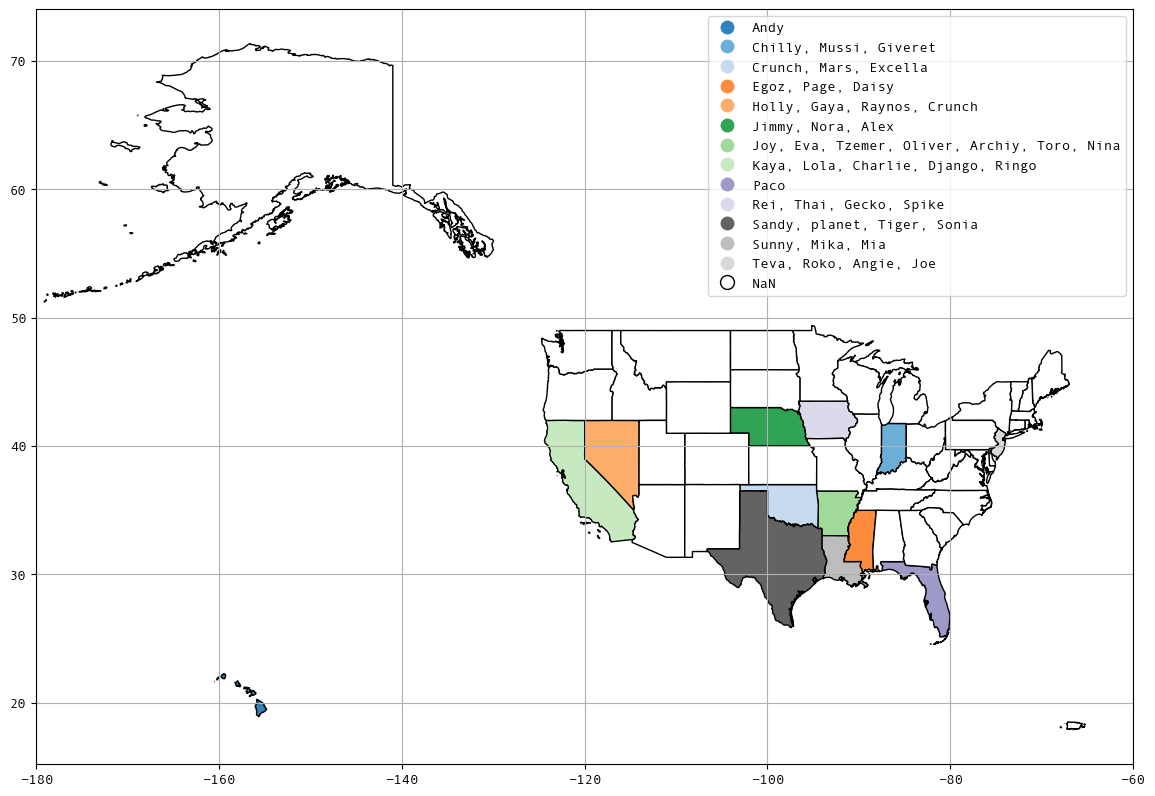

In [372]:
animal_states = US_STATES.join(animal_locations.set_index('state'), on='NAME')
animal_states.loc[animal_states.animal_name.isna(), 'animal_name'] = ""
plot_animal_states = gpd.GeoDataFrame(animal_states
                      .groupby(['NAME'], as_index=False)
                      .agg({'animal_name': lambda x: ', '.join(x)})
                      .merge(US_STATES, how='inner', on='NAME'))

plot_animal_states.loc[(plot_animal_states.animal_name==''), 'animal_name']=np.NaN

ax = plot_animal_states.plot(column='animal_name', missing_kwds = dict(color = "white",), cmap='tab20c', figsize=(15,10), legend=True, edgecolor='black')

ax.set_xlim(US_X_BOUNDS) # centers the plot on the united states by removing minor outlying islands from frame
plt.grid(True)

### Prepare Microbiome Dataframe

Preparing the microbiome dataframe, which has one row for every sample and one column for every family, takes two steps:
1. The dataset must bee pivoted so that 

#### Get, Pivot, and Clean Microbiome Data

In [476]:
sample_microbiome = pd.read_sql("""
SELECT 
    microbiome_sample.*, feature.*
FROM microbiome_sample 
JOIN feature ON microbiome_sample.sample_id=feature.sample_id;
""", con=con)

def clean_microbiome(df):
    df_copy = df.copy()
    
    # remove duplicate columns
    df_copy = df_copy.loc[:,~df_copy.columns.duplicated()]
    
    # pivot table so that each sample is a row and all features are in columns 
    df_copy = df_copy.pivot(index=['animal_id', 'sample_id'], columns=['feature_id'], values=['value']).reset_index()
    
    # flatten multiindex columns
    df_copy.columns = [''.join(col) if col[0]!='value' else col[1] for col in df_copy.columns]
    return df_copy
    
cleaned_sample_microbiome = clean_microbiome(sample_microbiome).set_index('sample_id')

In [477]:
cleaned_sample_microbiome.head()

,animal_id,000048f702075932f8490742242f53bc,0015c502708f2b691000338421d45481,0030768b412e89179a3e95e8314246e0,006340e125d729bc012b31674f8eeaab,0084d67b7c9244ff78f308d8353edc9e,008d968ec90dcc6308fef4db2234c8ae,00b112199d6818d465d04411f799c543,00b9c002ea861f3722335a25d0f74608,00c61f059eb6f8b869b01e6754fd0cd0,...,fd17074acfc5a30fc5f4b232526da760,fd2c75f35b6d3fe0063279bf346b5bf1,fd57a368f0d58e4a589a17acdeb79026,fdc0703fd7ed12b743799a4e5d14609a,fe0739bac994e3e75362a67c46a7d52c,fe37b8d76901ab8f244cc6091b28f043,fe951e497a18f389d934b58d62d0209a,feb56be9c36fafc5a551fb366c69f139,ff0af3e8ac32431bb0476639b81c7079,ffd8a12af6963db11835da7e472f401c
sample_id,,,,,,,,,,,,,,,,,,,,,
1-OK001-A,OK001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2-OK001-B,OK001,0,0,0,0,0,0,0,0,0,...,0,30,0,0,0,0,0,0,0,0
3-OK001-C,OK001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4-OK002-A,OK002,0,0,0,0,0,0,0,0,0,...,0,0,25,0,438,22,0,0,0,0
5-OK002-B,OK002,0,0,0,0,0,0,0,0,0,...,0,0,31,0,37,83,0,0,0,0


#### Create Taxonomy Map

In [466]:
taxonomy_map = pd.read_sql('SELECT * FROM taxonomy',con=con).set_index('feature_id')

taxonomy_map.drop(columns=['confidence'],inplace=True)
taxonomy_map.loc[:, 'taxon'] = taxonomy_map.loc[:, 'taxon'].str.split(';').apply(lambda x: tuple([element.split('__')[1] for element in x]))
for k, v in TAXONOMY_MAP.items():
    taxonomy_map[k] = taxonomy_map.loc[:, 'taxon'].str[v]

In [467]:
taxonomy_map.head()

,taxon,kingdom,phylum,class,order,family,genus,species
feature_id,,,,,,,,
e8b0442820438300eb33910c045c82e7,"(Bacteria, Firmicutes, Clostridia, Clostridial...",Bacteria,Firmicutes,Clostridia,Clostridiales,Peptostreptococcaceae,Peptoclostridium,uncultured bacterium
1354022b45b1d1a5a6246cffc62c6cf3,"(Bacteria, Fusobacteria, Fusobacteriia, Fusoba...",Bacteria,Fusobacteria,Fusobacteriia,Fusobacteriales,Fusobacteriaceae,Fusobacterium,gut metagenome
d7e6c5da1f4ae4fcbd3810a04955bf5a,"(Bacteria, Fusobacteria, Fusobacteriia, Fusoba...",Bacteria,Fusobacteria,Fusobacteriia,Fusobacteriales,Fusobacteriaceae,Fusobacterium,NaN
b98678d2f65161093b9d0fa91376f8b9,"(Bacteria, Bacteroidetes, Bacteroidia, Bactero...",Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,uncultured bacterium
1da577dc465e6353a7f50ff65ee262f4,"(Bacteria, Bacteroidetes, Bacteroidia, Bactero...",Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Prevotellaceae,Alloprevotella,NaN


In [468]:
for k in TAXONOMY_MAP:
    print(f'number of unique {k}: {taxonomy_map.loc[:,k].nunique()}')

number of unique kingdom: 2
number of unique phylum: 15
number of unique class: 22
number of unique order: 42
number of unique family: 76
number of unique genus: 214
number of unique species: 128


In [469]:
def group_by_taxonomy(value, taxonomy_map, level='family'): 
    # family was selected as default phylogenic level to reduce data dimensionality and allow for cleaner visualization
    return taxonomy_map.loc[value, level]
    

sample_family_microbiome = (cleaned_sample_microbiomes[feature_columns]
                            .groupby(lambda x: group_by_taxonomy(x, taxonomy_map), axis=1).agg(sum))

families = list(sample_family_microbiome.columns)
sample_family_microbiome['animal_id'] = cleaned_sample_microbiomes.loc[:, 'animal_id']

In [470]:
sample_family_microbiome.head()

,Acidaminococcaceae,Actinomycetaceae,Aerococcaceae,Akkermansiaceae,Alcanivoracaceae,Anaeroplasmataceae,Atopobiaceae,Bacillaceae,Bacteroidaceae,Barnesiellaceae,...,Staphylococcaceae,Streptococcaceae,Succinivibrionaceae,Tannerellaceae,Thermaceae,Veillonellaceae,uncultured,uncultured bacterium,uncultured rumen bacterium,animal_id
sample_id,,,,,,,,,,,,,,,,,,,,,
1-OK001-A,0,0,0,0,0,0,0,0,11,0,...,0,969,0,0,0,0,0,0,0,OK001
2-OK001-B,0,0,0,0,0,0,0,0,25,0,...,0,0,0,0,0,0,0,0,0,OK001
3-OK001-C,451,0,0,0,0,194,0,0,11041,0,...,0,0,304,0,0,1894,0,0,0,OK001
4-OK002-A,463,0,0,0,0,231,0,0,7838,0,...,0,5,3296,32,0,118,0,0,0,OK002
5-OK002-B,0,0,0,0,0,90,0,0,40,0,...,0,0,0,583,0,0,0,0,0,OK002


### Microbiome Prediction 

#### Prepare Animal Microbiomes

In [471]:
animal = pd.read_sql('SELECT * FROM animal', con=con)

animal_microbiome = sample_family_microbiome.merge(animal, on='animal_id', how='left')
animal_microbiome

,Acidaminococcaceae,Actinomycetaceae,Aerococcaceae,Akkermansiaceae,Alcanivoracaceae,Anaeroplasmataceae,Atopobiaceae,Bacillaceae,Bacteroidaceae,Barnesiellaceae,...,uncultured,uncultured bacterium,uncultured rumen bacterium,animal_id,animal_name,user_id,planet_of_origin,sex,age,life_stage
0,0,0,0,0,0,0,0,0,11,0,...,0,0,0,OK001,planet,38,Venus,female,3,Adult
1,0,0,0,0,0,0,0,0,25,0,...,0,0,0,OK001,planet,38,Venus,female,3,Adult
2,451,0,0,0,0,194,0,0,11041,0,...,0,0,0,OK001,planet,38,Venus,female,3,Adult
3,463,0,0,0,0,231,0,0,7838,0,...,0,0,0,OK002,Crunch,41,Venus,male,6,Senior
4,0,0,0,0,0,90,0,0,40,0,...,0,0,0,OK002,Crunch,41,Venus,male,6,Senior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0,0,0,0,0,0,0,0,6261,0,...,0,0,0,P0320,Mussi,8,Mars,female,4,Adult
119,1007,0,0,0,0,0,0,0,7580,0,...,0,0,0,P0321,Alex,34,Mars,female,7,Senior
120,283,0,0,0,0,0,0,0,3827,0,...,0,0,0,P0321,Alex,34,Mars,female,7,Senior
121,84,2,0,0,0,0,0,0,3258,0,...,0,0,0,P0321,Alex,34,Mars,female,7,Senior


### Predict Planet of Origin from Microbiome

A few considerations for this problem: 
- test size is set to .2, may need to be increased due to small sample size, 
- Samples are considered not individual animal. Some animals have duplicate entries because they were sampled multiple times. 
- Duplicates were included to try to filter out the noise of diet, time of sample.

In [472]:
Planet_X_train, Planet_X_test, Planet_y_train, Planet_y_test = train_test_split(
    animal_microbiome[families],
    animal_microbiome.planet_of_origin, 
    test_size=.2, 
    stratify=animal_microbiome.planet_of_origin)

In [473]:
Planet_y_train

95      Mars
35      Mars
3      Venus
105     Mars
56      Mars
       ...  
120     Mars
107     Mars
16     Venus
15     Venus
14     Venus
Name: planet_of_origin, Length: 98, dtype: object

#### Use Dimensionality Reduction Techniques to Analyze Potential Clusters and Linear Seperability

Ran microbiome data through a few dimensionality reduction algorithms to search for obvious clustering/linear seperability.

Due to the high dimensionality of the data, the results are not fruitful and analysis will not be repeated for other prob

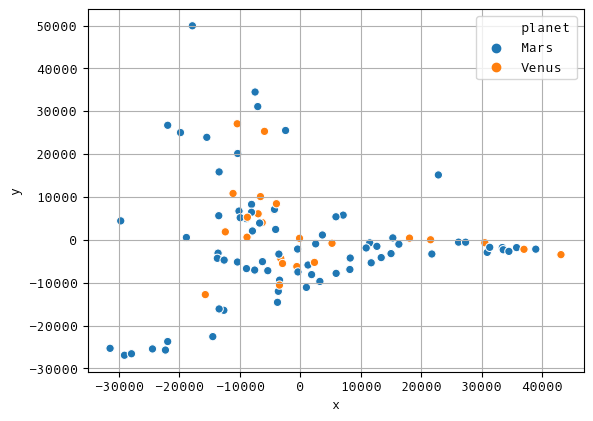

In [474]:
pca = PCA(n_components=2)
res = pca.fit_transform(Planet_X_train)

plot_pca = pd.DataFrame(res, columns=['x', 'y'])
plot_pca['planet'] = Planet_y_train.values
ax = sns.scatterplot(data=plot_pca, x='x', y='y', hue='planet', legend='full')
plt.grid(True)

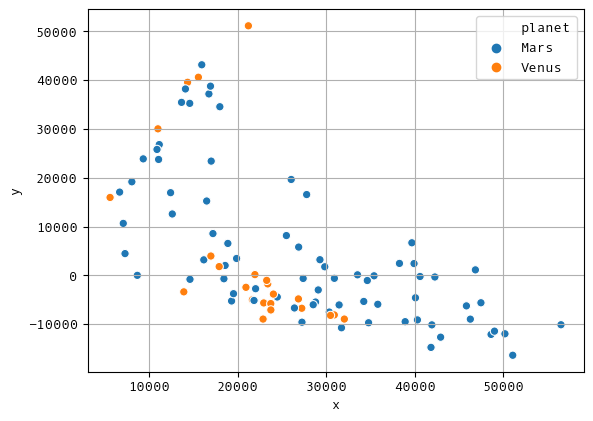

In [446]:
tsvd = TruncatedSVD()
res = tsvd.fit_transform(Planet_X_train)

plot_tsvd = pd.DataFrame(res, columns=['x', 'y'])
plot_tsvd['planet'] = Planet_y_train.values
ax = sns.scatterplot(data=plot_tsvd, x='x', y='y', hue='planet', legend='full')
plt.grid(True)

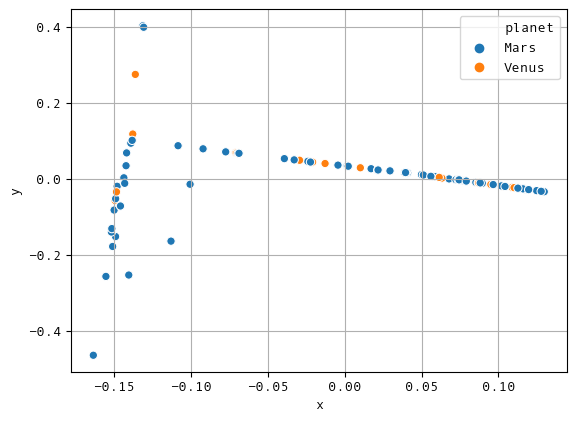

In [447]:
lle = LocallyLinearEmbedding()
res = lle.fit_transform(Planet_X_train)

planet_plot_lle = pd.DataFrame(res, columns=['x', 'y'])
planet_plot_lle['planet'] = Planet_y_train.values
ax = sns.scatterplot(data=planet_plot_lle, x='x', y='y', hue='planet', legend='full')

plt.grid(True)

#### Train Linear Classifier 

In [448]:
## SGD Being Used Because Dataset is wide: LinearClassifier would be quite slow

params = {
    'penalty': ['l1', 'l2']
}


sgd_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('grid', GridSearchCV(SGDClassifier(), param_grid=params, cv=3)),
])

sgd_pipe.fit(Planet_X_train, Planet_y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('grid',
                 GridSearchCV(cv=3, estimator=SGDClassifier(),
                              param_grid={'penalty': ['l1', 'l2']}))])

In [449]:
res = sgd_pipe.predict(Planet_X_train)

In [450]:
print('SGD Classfier: Using Microbiome to Predict Planet of Origin\n')
print(classification_report(Planet_y_train, res))

SGD Classfier: Using Microbiome to Predict Planet of Origin

              precision    recall  f1-score   support

        Mars       0.96      1.00      0.98        74
       Venus       1.00      0.88      0.93        24

    accuracy                           0.97        98
   macro avg       0.98      0.94      0.96        98
weighted avg       0.97      0.97      0.97        98



### Predict Sex of Animals using Microbiome

No new considersations for this problem

In [451]:
Sex_X_train, Sex_X_test, Sex_y_train, Sex_y_test = train_test_split(
    cleaned_animal_microbiome[feature_columns], 
    cleaned_animal_microbiome.sex, 
    test_size=.5, 
    stratify=cleaned_animal_microbiome.sex)

In [452]:
Sex_X_train.head()

,000048f702075932f8490742242f53bc,0015c502708f2b691000338421d45481,0030768b412e89179a3e95e8314246e0,006340e125d729bc012b31674f8eeaab,0084d67b7c9244ff78f308d8353edc9e,008d968ec90dcc6308fef4db2234c8ae,00b112199d6818d465d04411f799c543,00b9c002ea861f3722335a25d0f74608,00c61f059eb6f8b869b01e6754fd0cd0,00e2387b5dbdd3d3c5b3d3cdaae229e9,...,fd17074acfc5a30fc5f4b232526da760,fd2c75f35b6d3fe0063279bf346b5bf1,fd57a368f0d58e4a589a17acdeb79026,fdc0703fd7ed12b743799a4e5d14609a,fe0739bac994e3e75362a67c46a7d52c,fe37b8d76901ab8f244cc6091b28f043,fe951e497a18f389d934b58d62d0209a,feb56be9c36fafc5a551fb366c69f139,ff0af3e8ac32431bb0476639b81c7079,ffd8a12af6963db11835da7e472f401c
sample_id,,,,,,,,,,,,,,,,,,,,,
9-OK003-C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51-P0006-C,0,0,0,0,0,0,0,0,0,0,...,0,100,430,0,216,44,0,0,0,0
72-P0230-D,0,0,0,0,0,0,0,0,0,0,...,0,261,0,0,67,6,0,0,0,0
36-P0003-A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19-OK007-A,0,0,0,0,0,0,0,0,0,0,...,0,38,0,0,173,0,0,0,0,0


#### Train Linear Classifier 

In [453]:
## SGD Being Used Because Dataset is wide: LinearClassifier would be quite slow

params = {
    'penalty': ['l1', 'l2']
}


sgd_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('grid', GridSearchCV(SGDClassifier(), param_grid=params, cv=5)),
])

sgd_pipe.fit(Sex_X_train, Sex_y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('grid',
                 GridSearchCV(cv=5, estimator=SGDClassifier(),
                              param_grid={'penalty': ['l1', 'l2']}))])

In [454]:
res = sgd_pipe.predict(Sex_X_train)

In [455]:
print('SGD Classfier: Using Microbiome to Predict Sex of Animal\n')
print(classification_report(Sex_y_train, res))

SGD Classfier: Using Microbiome to Predict Sex of Animal

              precision    recall  f1-score   support

      female       1.00      1.00      1.00        32
        male       1.00      1.00      1.00        29

    accuracy                           1.00        61
   macro avg       1.00      1.00      1.00        61
weighted avg       1.00      1.00      1.00        61



In [456]:
print('SGD Classfier Test: Using Microbiome to Predict Planet of Origin\n')
print(classification_report(Sex_y_test, sgd_pipe.predict(Sex_X_test)))

SGD Classfier Test: Using Microbiome to Predict Planet of Origin

              precision    recall  f1-score   support

      female       0.68      0.81      0.74        32
        male       0.75      0.60      0.67        30

    accuracy                           0.71        62
   macro avg       0.72      0.71      0.70        62
weighted avg       0.72      0.71      0.71        62



### Predict Lifestage of Animal From Microbiome

In [457]:
Lifestage_X_train, Lifestage_X_test, Lifestage_y_train, Sex_y_test = train_test_split(
    cleaned_animal_microbiome[feature_columns], 
    cleaned_animal_microbiome.life_stage, 
    test_size=.2, 
    stratify=cleaned_animal_microbiome.life_stage)

In [458]:
Lifestage_X_train.head()

,000048f702075932f8490742242f53bc,0015c502708f2b691000338421d45481,0030768b412e89179a3e95e8314246e0,006340e125d729bc012b31674f8eeaab,0084d67b7c9244ff78f308d8353edc9e,008d968ec90dcc6308fef4db2234c8ae,00b112199d6818d465d04411f799c543,00b9c002ea861f3722335a25d0f74608,00c61f059eb6f8b869b01e6754fd0cd0,00e2387b5dbdd3d3c5b3d3cdaae229e9,...,fd17074acfc5a30fc5f4b232526da760,fd2c75f35b6d3fe0063279bf346b5bf1,fd57a368f0d58e4a589a17acdeb79026,fdc0703fd7ed12b743799a4e5d14609a,fe0739bac994e3e75362a67c46a7d52c,fe37b8d76901ab8f244cc6091b28f043,fe951e497a18f389d934b58d62d0209a,feb56be9c36fafc5a551fb366c69f139,ff0af3e8ac32431bb0476639b81c7079,ffd8a12af6963db11835da7e472f401c
sample_id,,,,,,,,,,,,,,,,,,,,,
31-P0001-A,0,0,0,0,0,0,0,31,0,0,...,0,36,8,0,0,0,0,0,0,0
78-P0251-B,0,0,35,0,0,0,0,0,0,0,...,0,61,499,0,0,45,0,0,0,0
70-P0230-B,0,0,0,0,0,0,0,0,0,0,...,0,32,61,0,31,83,0,0,0,0
80-P0251-D,0,0,0,0,0,0,0,0,0,0,...,0,384,96,0,0,195,0,0,0,0
51-P0006-C,0,0,0,0,0,0,0,0,0,0,...,0,100,430,0,216,44,0,0,0,0


#### Train Linear Classifier 

In [459]:
## SGD Being Used Because Dataset is wide: LinearClassifier would be quite slow

params = {
    'penalty': ['l1', 'l2']
}


sgd_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('grid', GridSearchCV(SGDClassifier(), param_grid=params, cv=4)),
])

sgd_pipe.fit(Lifestage_X_train, Lifestage_y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('grid',
                 GridSearchCV(cv=4, estimator=SGDClassifier(),
                              param_grid={'penalty': ['l1', 'l2']}))])

In [460]:
res = sgd_pipe.predict(Lifestage_X_train)

In [461]:
print('SGD Classfier: Using Microbiome to Predict Plane of Origin\n')
print(classification_report(Lifestage_y_train, res))

SGD Classfier: Using Microbiome to Predict Plane of Origin

              precision    recall  f1-score   support

       Adult       1.00      1.00      1.00        64
   Geriatric       1.00      1.00      1.00        10
      Senior       1.00      1.00      1.00        24

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98



### Finding Correlation between Physical and Microbiome

In [209]:
animal_physicals = pd.read_sql("""
    SELECT sample_id, weight, body_condition_score, pulse FROM physical_examination
    JOIN microbiome_sample ON 
        physical_examination.animal_id= microbiome_sample.animal_id AND physical_examination.test_date=microbiome_sample.test_date
""", con=con).set_index('sample_id')

In [270]:
animal_physicals.head()

,weight,body_condition_score,pulse
sample_id,,,
6-OK002-C,36.6,6.0,96.0
12-OK004-C,34.0,5.0,96.0
24-OK008-C,25.0,4.0,60.0
31-P0001-A,21.4,4.0,112.0
32-P0001-A2,21.4,4.0,112.0


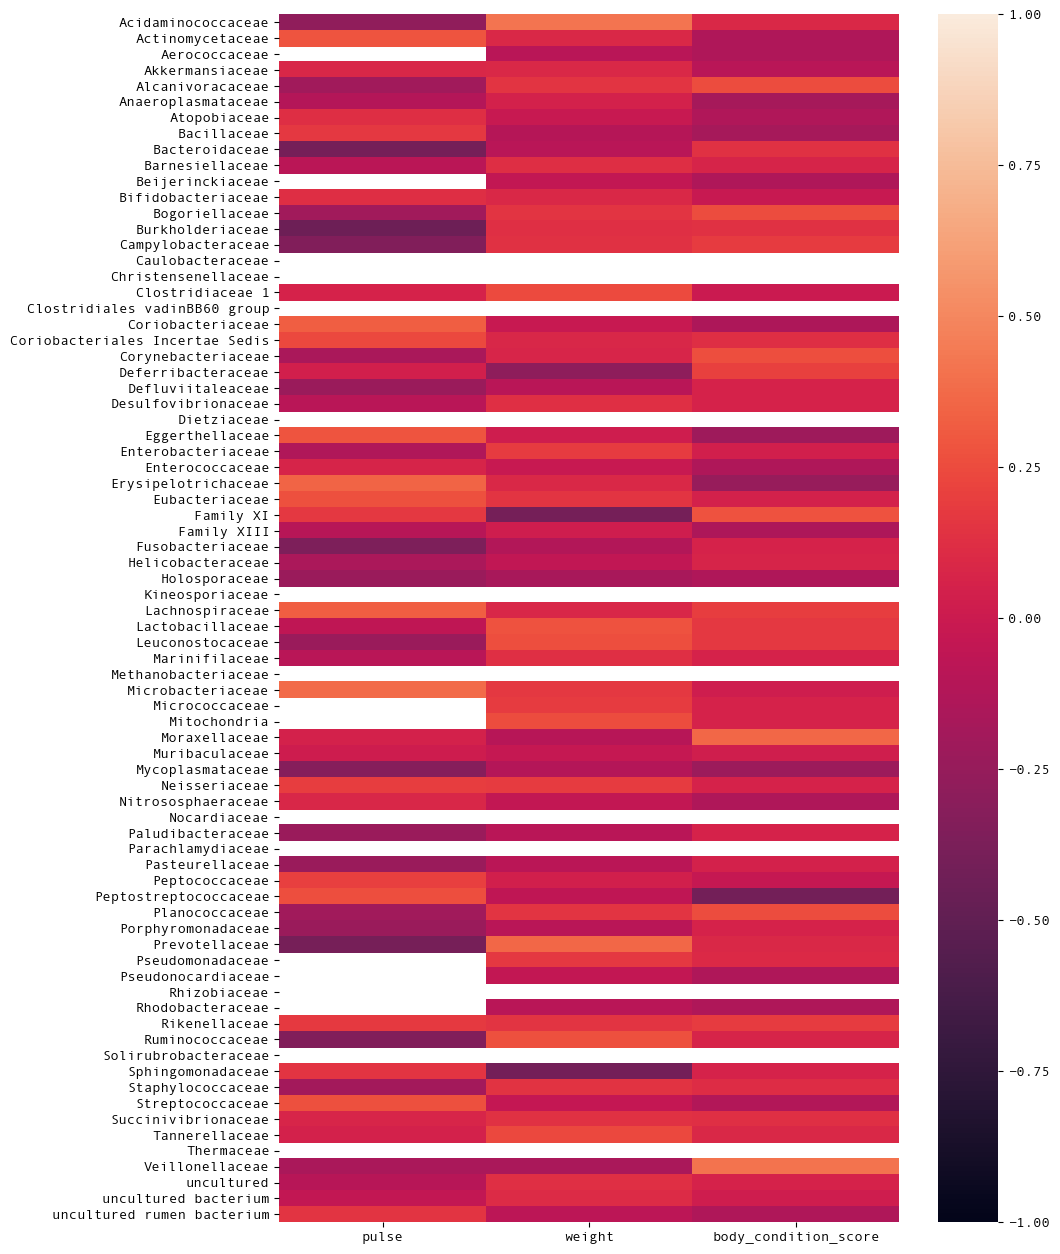

In [269]:
corr = animal_physicals.merge(family_microbiome, on='sample_id').corr()

fig = plt.figure(figsize=(10, 16))

family_physicals_corr = corr.loc[families, ['pulse', 'weight', 'body_condition_score']]
sns.heatmap(family_physicals_corr, vmin=-1, vmax=1)

### Finding Correlation between Daily Activity and Microbiome

In [204]:
daily_activity_microbiome = pd.read_sql("""
SELECT 
    daily_activity.*, microbiome_sample.*
FROM daily_activity
JOIN microbiome_sample ON 
    daily_activity.animal_id= microbiome_sample.animal_id AND daily_activity.test_date=microbiome_sample.test_date
""", con=con)


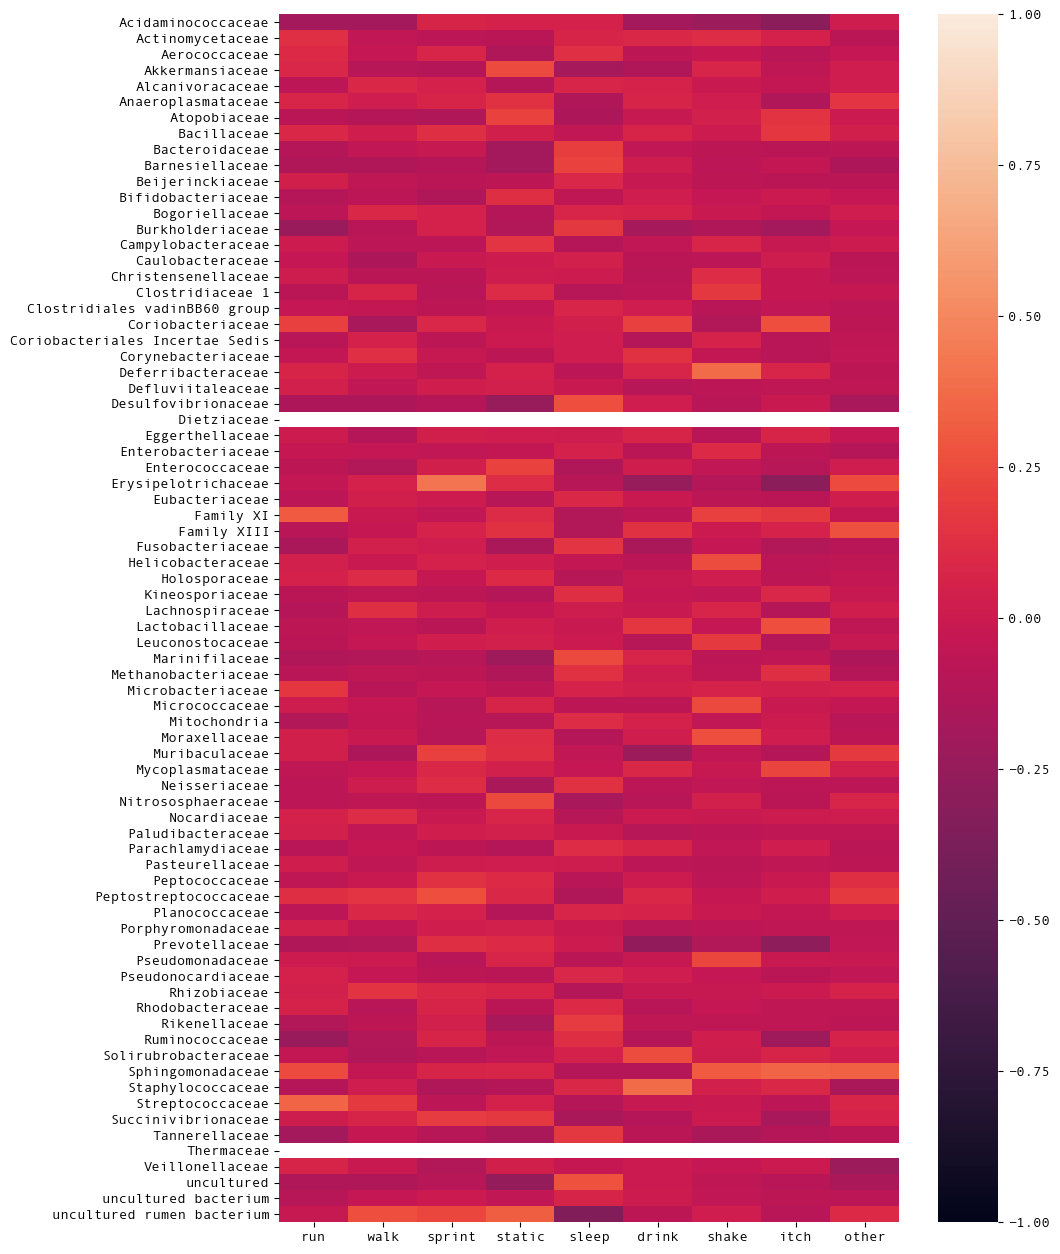

In [267]:
corr = daily_activity_microbiome.merge(family_microbiome, on='sample_id').corr()

fig = plt.figure(figsize=(10, 16))
family_exercise_corr = corr.loc[families, ['run', 'walk', 'sprint', 'static', 'sleep', 'drink', 'shake', 'itch', 'other']]

sns.heatmap(family_exercise_corr, vmin=-1, vmax=1)

### Finding Correlation between Diet and Microbiome

Since event_id is missing from the dataset, food is joined to the microbiome samples if:
- animal_id matches
- the sample_id date falls between the diet dates in the dataset.

If the endpoint of the diet is missing, it is assumed to be a month from the start date: this is the pattern in the rest of the dataset.

In [345]:
animal_diet = pd.read_sql("""
SELECT 
    microbiome_sample.sample_id,microbiome_sample.test_date, food.*
FROM diet_profile 
JOIN food_for_diet ON 
    diet_profile.diet_id=food_for_diet.diet_id
JOIN food ON
    food_for_diet.food_id=food.food_id
JOIN microbiome_sample ON
    diet_profile.animal_id=microbiome_sample.animal_id 
    AND 
    microbiome_sample.test_date>=diet_profile.diet_start_date 
    AND 
    microbiome_sample.test_date<COALESCE(diet_profile.diet_end_date, diet_profile.diet_start_date + INTERVAL '1 MONTH')
""", con=con).set_index('sample_id')

In [363]:
# Correlation can only be done on numeric values so One Hot Encoding is applied to main protein and food_category variables.

ohe_protein = pd.get_dummies(animal_diet.main_protein, prefix='protein')
ohe_general_cat = pd.get_dummies(animal_diet.general_category, prefix='is')
animal_diet_cat = (animal_diet
               .drop(columns=['main_protein', 'general_category'])
               .join(ohe_protein)
               .join(ohe_general_cat))

In [364]:
animal_diet_cat.head()

,test_date,food_id,input_date,product_name,energy_kcal_kg,moisture_persent,crude_protein_dry,crude_fat_dry,crude_fiber_dry,crude_ash_dry,...,fat_protein_ratio,fiber_nfe_ratio,carbs_protein_ratio,protein_chicken,protein_duck,protein_fish,protein_lamb,protein_turkey,is_dry,is_fresh
sample_id,,,,,,,,,,,,,,,,,,,,,
1-OK001-A,2020-04-10,1,2020-06-22,A,1312.0,70.0,0.460000,0.196667,0.086667,0.066667,...,0.427536,0.456140,0.413043,0,0,0,0,1,0,1
2-OK001-B,2020-05-10,2,2020-06-22,A,3493.0,12.0,0.329545,0.193182,0.056818,0.085227,...,0.586207,0.169492,1.017241,0,0,1,0,0,1,0
4-OK002-A,2020-04-10,3,2020-06-22,C,3638.0,10.0,0.288889,0.157778,0.038889,0.072222,...,0.546154,0.087940,1.530769,1,0,0,0,0,1,0
5-OK002-B,2020-05-10,3,2020-06-22,C,3638.0,10.0,0.288889,0.157778,0.038889,0.072222,...,0.546154,0.087940,1.530769,1,0,0,0,0,1,0
7-OK003-A,2020-04-10,7,2020-06-22,E,4020.0,10.0,0.300000,0.200000,0.044444,0.088889,...,0.666667,0.121212,1.222222,1,0,0,0,0,1,0


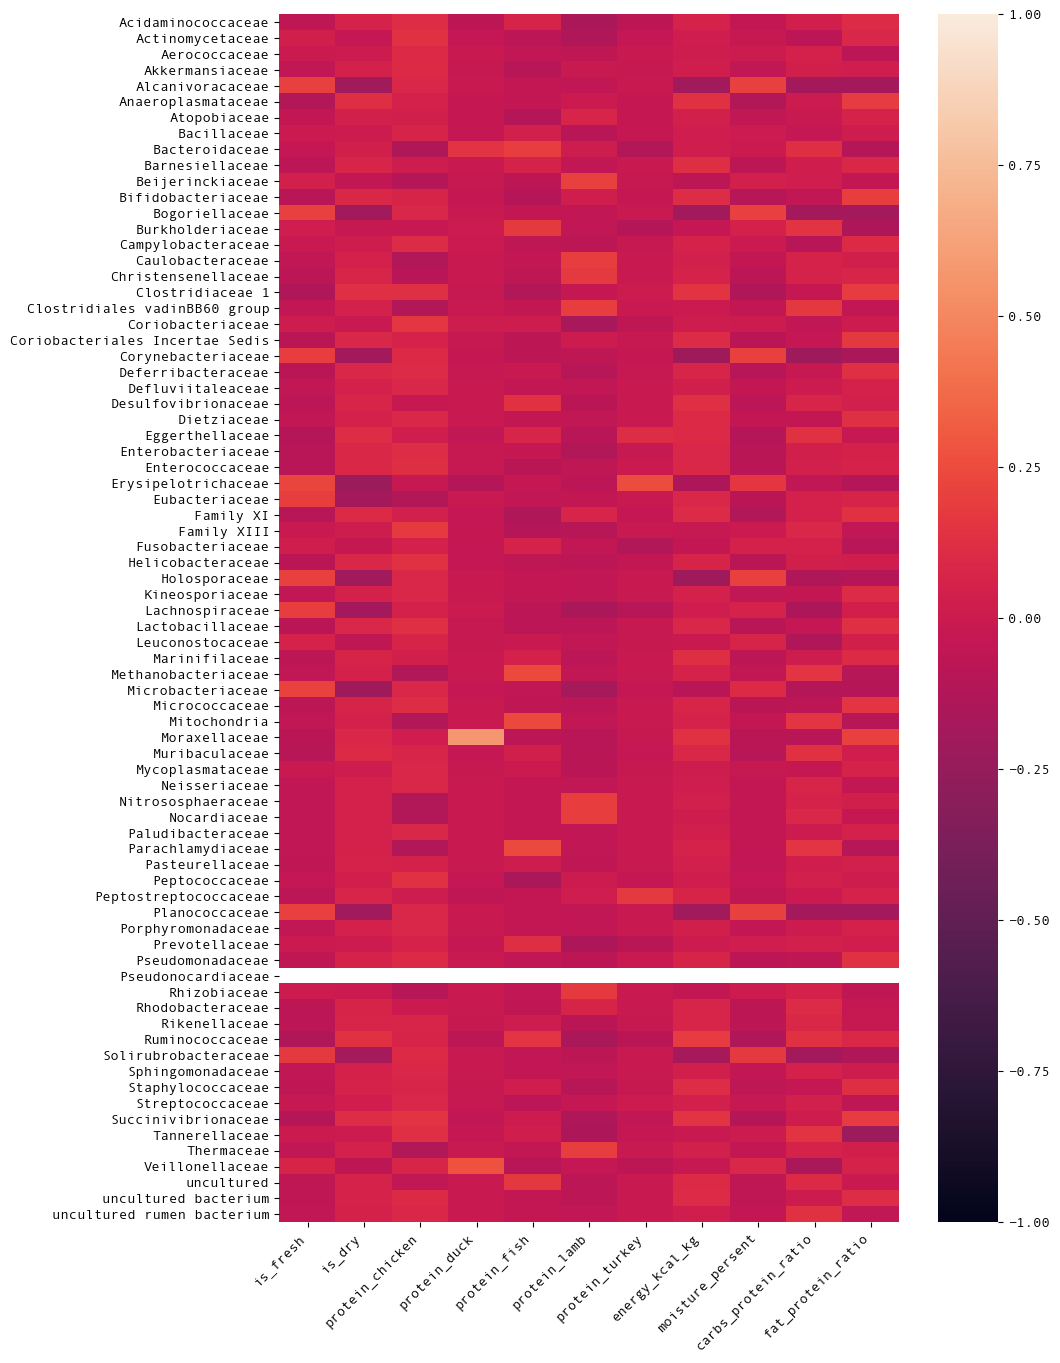

In [362]:
corr = animal_diet_cat.merge(family_microbiome, on='sample_id').corr()

fig = plt.figure(figsize=(10, 16))
family_diet_corr = corr.loc[families, ['is_fresh', 'is_dry', 'protein_chicken', 'protein_duck', 'protein_fish', 'protein_lamb', 'protein_turkey', 'energy_kcal_kg', 'moisture_persent', 'carbs_protein_ratio', 'fat_protein_ratio']]

ax = sns.heatmap(family_diet_corr, vmin=-1, vmax=1)
plt.xticks(rotation='45', ha='right')
plt.show()

## FURTHER RESEARCH

### Identify Physically Correlated Organisms 

Use pearson correlation to find correlated and anti correlated animals by physical information

In [35]:
animal_physicals = pd.read_sql('SELECT animal_id, weight, body_condition_score, pulse FROM physical_examination', con=con).set_index('animal_id')

In [36]:
animal_physicals.isna().sum()

weight                   0
body_condition_score     2
pulse                   35
dtype: int64

In [37]:
physical_features = ['weight', 'body_condition_score', 'pulse']

physical_prep = Pipeline([
    ('knn', KNNImputer()),
    ('sc', StandardScaler())
])

cleaned_animal_physicals = animal_physicals.copy()
cleaned_animal_physicals[physical_features] = physical_prep.fit_transform(animal_physicals[physical_features])

In [38]:
# Verify that there are no missing features
cleaned_animal_physicals.isna().sum()

weight                  0
body_condition_score    0
pulse                   0
dtype: int64

### Impute Missing Values using KNN and Standardize Values

In [39]:
transposed_animals = cleaned_animal_physicals.T

In [40]:
transposed_animals.head()

animal_id,OK001,OK002,OK003,OK004,OK005,OK006,OK007,OK008,OK009,OK010,...,P0311,P0311,P0313,P0313,P0313,P0320,P0320,P0321,P0321,P0321
weight,-1.760957,1.715671,0.113812,1.407165,0.683362,1.086793,1.300374,0.339259,-0.681185,2.237759,...,0.054484,0.125678,0.576571,0.339259,0.351124,-2.033866,-2.033866,-0.004844,0.256199,0.090081
body_condition_score,1.223503,1.223503,-1.168637,0.027433,0.027433,-1.168637,-1.168637,-1.168637,0.027433,0.027433,...,-1.168637,-1.168637,-1.168637,-1.168637,-1.168637,0.027433,0.027433,-1.168637,-1.168637,-1.168637
pulse,0.776757,-0.880122,1.368500,-0.880122,-0.406728,-1.353516,0.540060,-3.010395,-2.537001,-0.170031,...,0.303363,0.090336,0.540060,-0.146361,-0.146361,0.540060,0.729418,-0.170031,1.250151,0.090336


In [41]:
transposed_animals.corr()

animal_id,OK001,OK002,OK003,OK004,OK005,OK006,OK007,OK008,OK009,OK010,...,P0311,P0311,P0313,P0313,P0313,P0320,P0320,P0321,P0321,P0321
animal_id,,,,,,,,,,,,,,,,,,,,,
OK001,1.000000,-0.534425,-0.145021,-0.855547,-0.854663,-0.978589,-0.823854,-0.751610,-0.113293,-0.977371,...,-0.483120,-0.634055,-0.629666,-0.832585,-0.835823,0.946534,0.926388,-0.713418,-0.239360,-0.615201
OK002,-0.534425,1.000000,-0.758778,0.894815,0.895575,0.696948,-0.038781,0.959190,0.900321,0.701122,...,-0.481841,-0.314740,-0.320110,-0.023209,-0.017339,-0.778521,-0.813369,-0.211007,-0.692726,-0.337565
OK003,-0.145021,-0.758778,1.000000,-0.388180,-0.389751,-0.061732,0.680286,-0.543636,-0.966628,-0.067556,...,0.936361,0.857065,0.859968,0.668785,0.664408,0.181925,0.238245,0.796792,0.995379,0.869254
OK004,-0.855547,0.894815,-0.388180,1.000000,0.999999,0.943789,0.411399,0.984533,0.611319,0.945702,...,-0.039965,0.142113,0.136506,0.425549,0.430855,-0.976824,-0.987529,0.247573,-0.297892,0.118174
OK005,-0.854663,0.895575,-0.389751,0.999999,1.000000,0.943224,0.409844,0.984830,0.612668,0.945147,...,-0.041669,0.140425,0.134816,0.424005,0.429315,-0.976458,-0.987259,0.245920,-0.299519,0.116480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P0320,0.946534,-0.778521,0.181925,-0.976824,-0.976458,-0.992667,-0.596954,-0.924216,-0.427762,-0.993356,...,-0.174832,-0.350689,-0.345381,-0.609381,-0.614026,1.000000,0.998341,-0.449214,0.086663,-0.327977
P0320,0.926388,-0.813369,0.238245,-0.987529,-0.987259,-0.984060,-0.549767,-0.944671,-0.479100,-0.985081,...,-0.117847,-0.296182,-0.290769,-0.562714,-0.567558,0.998341,1.000000,-0.397023,0.143885,-0.273036
P0321,-0.713418,-0.211007,0.796792,0.247573,0.245920,0.553915,0.984932,0.073999,-0.615402,0.549046,...,0.958201,0.994219,0.993595,0.982118,0.980996,-0.449214,-0.397023,1.000000,0.851132,0.991337


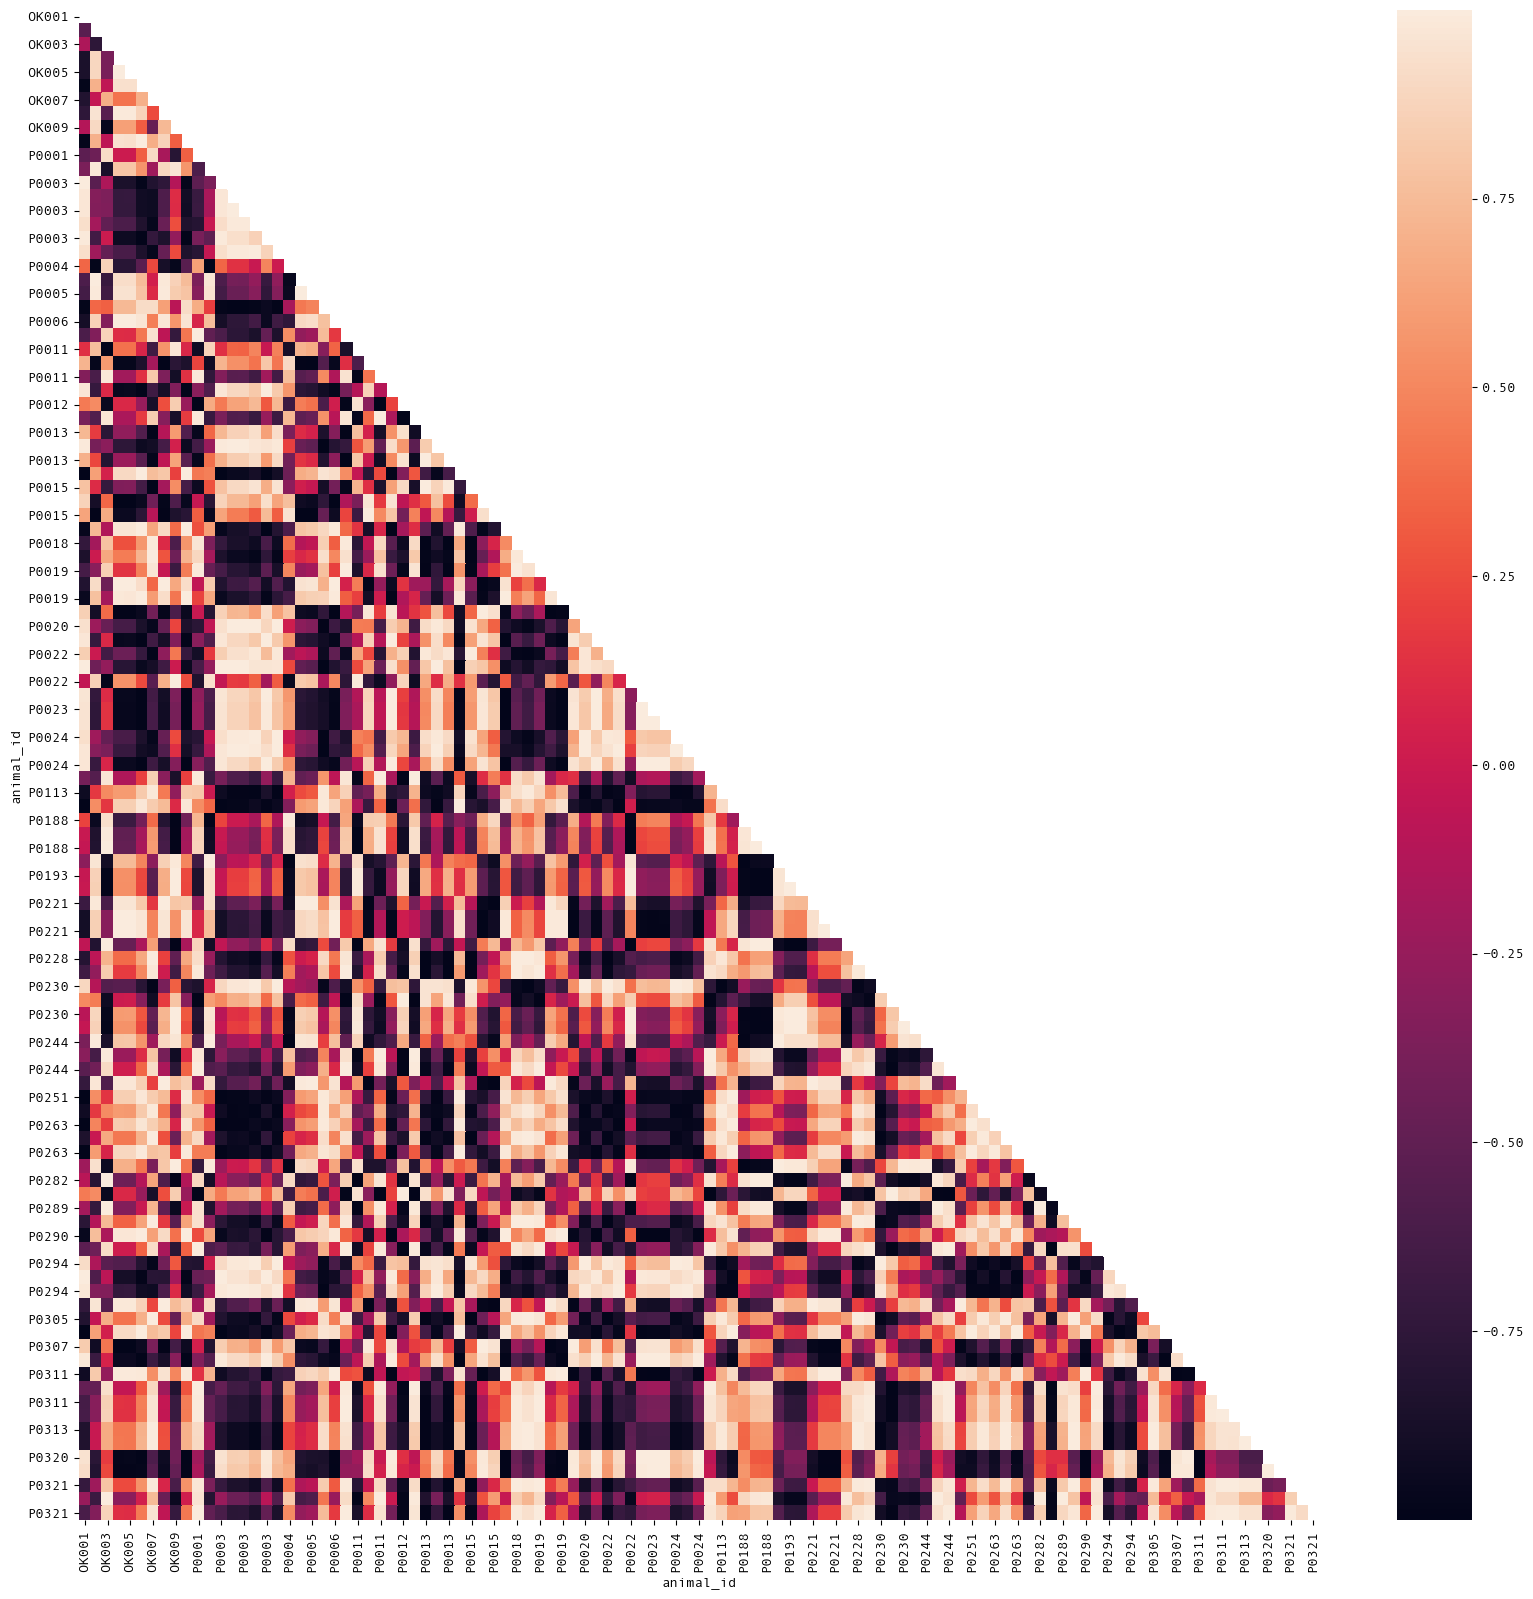

In [42]:
corr = transposed_animals.corr()
ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr, mask=np.triu(np.ones_like(corr)))

In [47]:
corr[(corr>.99)|(corr<-.99)]

animal_id,OK001,OK002,OK003,OK004,OK005,OK006,OK007,OK008,OK009,OK010,...,P0311,P0311,P0313,P0313,P0313,P0320,P0320,P0321,P0321,P0321
animal_id,,,,,,,,,,,,,,,,,,,,,
OK001,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OK002,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OK003,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.995379,NaN
OK004,NaN,NaN,NaN,1.000000,0.999999,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OK005,NaN,NaN,NaN,0.999999,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P0320,NaN,NaN,NaN,NaN,NaN,-0.992667,NaN,NaN,NaN,-0.993356,...,NaN,NaN,NaN,NaN,NaN,1.000000,0.998341,NaN,NaN,NaN
P0320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.998341,1.000000,NaN,NaN,NaN
P0321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.994219,0.993595,NaN,NaN,NaN,NaN,1.000000,NaN,0.991337
